# Build and test some models

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
#import psycopg2
import sql_utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
import pickle
import time
%matplotlib inline

## Pull the data from postgres

In [3]:
# select and join the BART and weather data
# select and join the BART and weather data from postgres
bart_weather_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='weather',
                           on1='bart_entry_exit.date', on2='weather.datestamp')

In [4]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,exits,day,month,id,datestamp,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
1,1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
2,2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
3,3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
4,4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1


In [6]:
# remove the redundant 'id' and 'datestamp' columns
bart_weather_df.drop(labels=['id', 'datestamp'], axis=1, inplace=True)
bart_weather_df.head()

,date,hour,direction,station,entries,exits,day,month,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,43.0,45.0,40.0,0.36,1
1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,43.0,45.0,40.0,0.36,1
2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,43.0,45.0,40.0,0.36,1
3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,43.0,45.0,40.0,0.36,1
4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,43.0,45.0,40.0,0.36,1


-------
## Transform features before feeding to model
Generate some new features, and transform categorical features to binary dummy variables 

In [118]:
# take a look at the current data types
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126069 entries, 0 to 2126068
Data columns (total 13 columns):
date                object
hour                object
direction           object
station             object
entries             int64
exits               int64
day                 object
month               object
mean_temperature    float64
max_temperature     float64
min_temperature     float64
precipitation       float64
rain                int64
dtypes: float64(4), int64(3), object(6)
memory usage: 210.9+ MB


In [233]:
# restrict to only the columns to be used in the models
model_data = bart_weather_df[['hour', 'direction', 'station', 'entries', 
                              'day','month', 'max_temperature', 'rain']]
# remove NaN from data before training
model_data = model_data.loc[(~model_data.isnull().any(axis=1)), :]

 ### Transform categorical features to binary dummy variables

In [234]:
# create a weekday dummy variable
model_data['weekday'] = 0
model_data.loc[model_data['day'].isin([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday'] = 1

In [235]:
# transform direction to binary dummy
model_data['northbound'] = 0
model_data.loc[model_data['direction'] == 'northbound', 'northbound'] = 1
# drop the original categorical feature
model_data.drop('direction', axis=1, inplace=True)

In [236]:
model_data.head()

,hour,station,entries,day,month,max_temperature,rain,weekday,northbound
0,0,12TH,16,Saturday,1,45.0,1,0,1
1,0,16TH,168,Saturday,1,45.0,1,0,1
2,0,19TH,19,Saturday,1,45.0,1,0,1
3,0,24TH,72,Saturday,1,45.0,1,0,1
4,0,BALB,72,Saturday,1,45.0,1,0,1


In [238]:
# transform categorical features into binary dummy variables
model_data_binary = pd.get_dummies(model_data)

In [239]:
model_data_binary.head()

,entries,max_temperature,rain,weekday,northbound,hour_0,hour_1,hour_10,hour_11,hour_12,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,16,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,168,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
model_data_binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126069 entries, 0 to 2126068
Data columns (total 72 columns):
entries            int64
max_temperature    float64
rain               int64
weekday            int64
northbound         int64
hour_0             uint8
hour_1             uint8
hour_10            uint8
hour_11            uint8
hour_12            uint8
hour_13            uint8
hour_14            uint8
hour_15            uint8
hour_16            uint8
hour_17            uint8
hour_18            uint8
hour_19            uint8
hour_2             uint8
hour_20            uint8
hour_21            uint8
hour_22            uint8
hour_23            uint8
hour_3             uint8
hour_4             uint8
hour_5             uint8
hour_6             uint8
hour_7             uint8
hour_8             uint8
hour_9             uint8
station_12TH       uint8
station_16TH       uint8
station_19TH       uint8
station_24TH       uint8
station_BALB       uint8
station_CIVC       uint8
station_CO

-------
# Linear Regression
Train regression models to predict passenger crowding using the above features. 

## Least-squares regression
First, use a simple *ordinary least-squares (OLS) regression* model

#### Partition data for validation
Partition into 80% training set and 20% test set. 

In [248]:
X = model_data_binary.drop('entries', axis=1) # features = all columns except 'entries'
y = model_data_binary['entries']

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Train model
Fit an OLS regression model to the training data

In [250]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate model predictions

In [251]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

In [252]:
predictions = lm.predict(X_test)

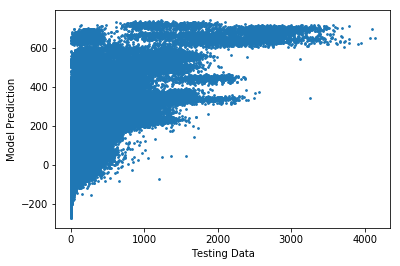

In [253]:
plt.scatter(y_test, predictions, s=3)
plt.xlabel('Testing Data')
plt.ylabel('Model Prediction')
plt.savefig(figpath + 'ols_predict.png')

Looks like the OLS model is pretty biased. This is likely due to the extreme outliers of the high-volume stations at high-volume times (e.g., downtown SF stations at rushour).

### Evaluate model

In [254]:
print('RSS: ', sum((y_test - predictions)**2))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', metrics.r2_score(y_test, predictions))

RSS:  28938547159.113773
MAE: 154.935119327
MSE: 68056.4307833
RMSE: 260.876274857
R^2:  0.289005124996


#### Residuals

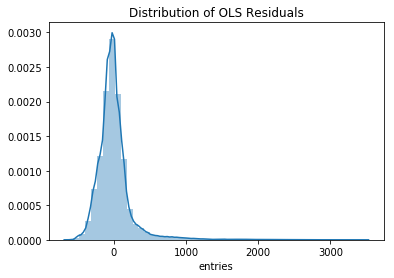

In [210]:
sns.distplot((y_test-predictions),bins=50);
plt.title('Distribution of OLS Residuals')
plt.savefig(figpath + 'ols_resid.png')

In [167]:
# dump model to pickle file so I can pick it up in Flask
with open('lm.pkl', 'wb') as fid:
    pickle.dump(lm, fid,2) 

In [168]:
#For building feature vectors, create a dataframe with the dummy variables
feats = model_data_binary.drop('entries', axis=1)
index_dict = dict(zip(feats.columns,range(feats.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 

## Ridge Regression
OLS did not perform very good. With the one-hot encoding of multi-class categoricals, we ended up with 70+ features. This might lead to an over-fitting to the training data. Let's use a ridge regression to impart some regularization and shrink the less informative features.

### Train model
Fit ridge model under each tuning value, and select best penalty (`alpha`) using cross-validation.  

In [192]:
# define array of tuning values to test
tuning = np.logspace(0, 7, num=15)
# fit ridge model to data using 10-fold CV
ridge = RidgeCV(alphas=tuning, cv=10)

In [193]:
# start timer
start = time.time()

ridge.fit(X, y)

# end timer
end = time.time()
elapsed = end-start
print(str(elapsed/60) + ' minutes elapsed' )

34.65736091931661 minutes elapsed


In [194]:
print('Optimal tuning parameter value: ', ridge.alpha_)

Optimal tuning parameter value:  1000.0


### Evaluate model predictions

In [195]:
ridge_predictions = ridge.predict(X)

In [196]:
print('MSE:', metrics.mean_squared_error(y, ridge_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, ridge_predictions)))
print('R^2: ', ridge.score(X, y))

MSE: 67967.7997637
RMSE: 260.706347763
R^2:  0.288578701692


No improvement in model fit compared to the simple OLS regression. Predictions are still pretty biased, as shown below. Perhaps a polynomial model would improve things.

Text(0,0.5,'Ridge-Predicted Crowd Levels')

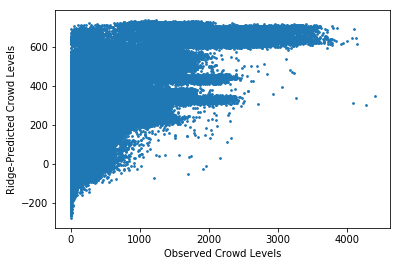

In [198]:
plt.scatter(y, ridge_predictions, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Ridge-Predicted Crowd Levels')

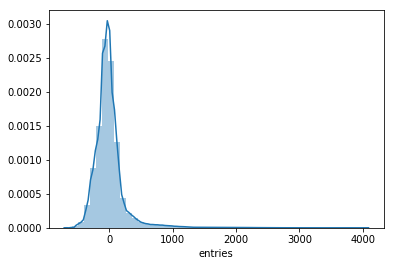

In [199]:
sns.distplot((y-ridge_predictions),bins=50)

## Support Vector Regression

In [ ]:
svr_lin = SVR(kernel='linear', C=1e3)
y_lin = svr_lin.fit(X, y).predict(X)